In [563]:
from typing import Dict, List
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import surprise
from surprise import SVD
from surprise import Dataset
from surprise import Reader
from surprise import evaluate, print_perf
from surprise import KNNBasic,KNNWithMeans,KNNBaseline

In [564]:
dt = pd.read_csv('/Users/youyang/Downloads/ratings_Grocery_and_Gourmet_Food.csv')

In [565]:
dt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1297155 entries, 0 to 1297154
Data columns (total 4 columns):
A1ZQZ8RJS1XVTX    1297155 non-null object
0657745316        1297155 non-null object
5.0               1297155 non-null float64
1381449600        1297155 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 39.6+ MB


In [566]:
dt.head()


,A1ZQZ8RJS1XVTX,0657745316,5.0,1381449600
0,A31W38VGZAUUM4,0700026444,5.0,1354752000
1,A3I0AV0UJX5OH0,1403796890,1.0,1385942400
2,A3QAAOLIXKV383,1403796890,3.0,1307836800
3,AB1A5EGHHVA9M,141278509X,5.0,1332547200
4,A3DTB6RVENLQ9Q,1453060375,1.0,1362268800


In [567]:
dt.columns = ['reviewerID','productID','rating','unixTime']

In [568]:
dt['unixTime'] = pd.to_datetime(dt['unixTime'],unit='s')
dt = dt.rename(columns={'unixTime':'date'})
#Only take recent reviews
dt = dt.loc[dt['date']>'2014-01-01']
#Last Date
dt['date'].max()

Timestamp('2014-07-23 00:00:00')

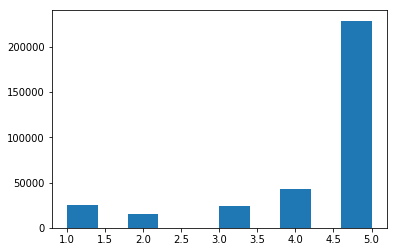

In [569]:
#Histogram of ratings
rating_hist = plt.hist(dt['rating'],align='mid')
#Group by product ID to count reviews per product
item_groupby = dt.groupby('productID',as_index=False)
review_count = item_groupby['reviewerID'].count()
review_count.columns = ['productID','count_review']

In [570]:
review_count.head()

,productID,count_review
0,1603112251,1
1,1613170416,3
2,1837994021,1
3,3295000018,13
4,3301261876,6


In [571]:
#Randomly select products from subset of products with at least a number of reviews
review_number = 10
product_sample_number = 100
product_list = review_count[review_count['count_review']>=review_number]
random_product = product_list.take(np.random.permutation(len(product_list))[:item_sample_number])
random_product_list = random_product['productID']

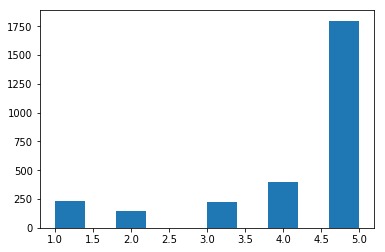

In [572]:
#Merge these products with original rating data
data = dt.loc[dt['productID'].isin(random_product_list)].reset_index(drop=True)
rating_hist = plt.hist(data['rating'],align='mid')
#Write to a CSV file
data.to_csv('/Users/youyang/PycharmProjects/jupyter/personalization/sample_data')

In [573]:
data.head
data.describe

<bound method NDFrame.describe of           reviewerID   productID  rating       date
0     A2OJCU16OZYVLV  B0000531B7     4.0 2014-03-08
1     A1WU813U3EB31J  B0000531B7     5.0 2014-06-23
2      AKQW234XJ6RSV  B0000531B7     5.0 2014-06-24
3     A2BCHUOOIJL2K9  B0000531B7     5.0 2014-01-04
4     A2QXW9IMTMVS6D  B0000531B7     4.0 2014-01-16
5     A3ETVU6MI11MNT  B0000531B7     5.0 2014-03-30
6     A2D87C4DVHLQLK  B0000531B7     3.0 2014-05-13
7      ATN5X2PM7OB3K  B0000531B7     5.0 2014-07-01
8     A1MAMHM2HG12KV  B0000531B7     4.0 2014-01-26
9     A2BYV7S1QP2YIG  B0000531B7     5.0 2014-04-10
10    A2ET4FDDQK1S8M  B0000531B7     4.0 2014-02-24
11    A2RHGMIYMF96IU  B0000531B7     5.0 2014-06-27
12    A1MU1VKXNDLP0R  B0000531B7     5.0 2014-05-23
13    A1SMX19RF2Q6WQ  B0000531B7     4.0 2014-06-28
14    A1A5YHS2SHXD2A  B0000531B7     5.0 2014-06-07
15     A5W8NNGW02JUU  B0000531B7     4.0 2014-07-09
16     AB1TGL9KAQDX3  B0000531B7     5.0 2014-05-30
17    A3715AT2EUT0AL  B0000531

# K-NN

In [574]:
# load data
reader = Reader(rating_scale=(1,5))
data = Dataset.load_from_df(data[['reviewerID','productID','rating']],reader)

In [575]:

    

## 
folds_number = 5
same_dataset = True

## define algorithm config
algo_name = KNNBasic ##  KNNWithMeans,KNNBaseline
train_sim_option={'name': 'msd', ## cosine, msd, pearson, personbaseline
                 'user_based': 'False', ## False for item-based
                 'min_surpport':0 }##  if |Iuv|<min_support then sim(u,v)=0
max_k = 40 ## The (max) number of neighbors to take into account for aggregation
min_k = 1 ##  If there are not enough neighbors, the prediction is set the the global mean of all ratings

## define evaluate setting
measure_way = ['RMSE', 'MAE'] ## fcp
verbose = 1

## define parameters of gridsearch
# grid_param = {'k':list(range(35,46)),
#              'min_k':list(range(0,11)),
#              'sim_options':sim_option_list(name = ['msd','cosine','pearson'],min_support=[0,1,2,3,4,5])
#              }
grid_param = {'k':[20,30,40,50,60],
             'min_k':[1,5,10],
             'sim_options':{'name':['msd','cosine','pearson'],
                           'min_surpport':[0,3,5],
                           'user_based':[False]}
             }


In [576]:
data.split(n_folds=folds_number, shuffle= same_dataset)
algo = algo_name(k = max_k, min_k = min_k, sim_options=train_sim_option)

In [577]:
perf = evaluate(algo, data, measures=measure_way, verbose= verbose)

Evaluating RMSE, MAE of algorithm KNNBasic.

------------
Fold 1
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 1.2697
MAE:  1.0072
------------
Fold 2
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 1.2514
MAE:  0.9804
------------
Fold 3
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 1.2237
MAE:  0.9824
------------
Fold 4
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 1.3248
MAE:  1.0564
------------
Fold 5
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 1.3149
MAE:  1.0520
------------
------------
Mean RMSE: 1.2769
Mean MAE : 1.0157
------------
------------


In [578]:

## have a deep look

# for trainset, testset in data.folds():
    # train and test algorithm.
#     algo.train(trainset)
#     predictions = algo.test(testset)
#     print("{test},{pred}".format(test = testset,pred=predictions))
    

In [579]:
grid_search = surprise.GridSearch(algo_name, grid_param, measures=['RMSE', 'MAE'],verbose = 2)

[{'k': 20, 'min_k': 1, 'sim_options': {'name': 'msd', 'min_surpport': 0, 'user_based': False}}, {'k': 20, 'min_k': 1, 'sim_options': {'name': 'msd', 'min_surpport': 3, 'user_based': False}}, {'k': 20, 'min_k': 1, 'sim_options': {'name': 'msd', 'min_surpport': 5, 'user_based': False}}, {'k': 20, 'min_k': 1, 'sim_options': {'name': 'cosine', 'min_surpport': 0, 'user_based': False}}, {'k': 20, 'min_k': 1, 'sim_options': {'name': 'cosine', 'min_surpport': 3, 'user_based': False}}, {'k': 20, 'min_k': 1, 'sim_options': {'name': 'cosine', 'min_surpport': 5, 'user_based': False}}, {'k': 20, 'min_k': 1, 'sim_options': {'name': 'pearson', 'min_surpport': 0, 'user_based': False}}, {'k': 20, 'min_k': 1, 'sim_options': {'name': 'pearson', 'min_surpport': 3, 'user_based': False}}, {'k': 20, 'min_k': 1, 'sim_options': {'name': 'pearson', 'min_surpport': 5, 'user_based': False}}, {'k': 20, 'min_k': 5, 'sim_options': {'name': 'msd', 'min_surpport': 0, 'user_based': False}}, {'k': 20, 'min_k': 5, 'sim_o

In [580]:
grid_search.evaluate(data)

------------
Parameters combination 1 of 135
params:  {'k': 20, 'min_k': 1, 'sim_options': {'name': 'msd', 'min_surpport': 0, 'user_based': False}}
Evaluating RMSE, MAE of algorithm KNNBasic.

------------
Fold 1
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 1.2634
MAE:  1.0019
------------
Fold 2
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 1.2506
MAE:  0.9786
------------
Fold 3
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 1.2201
MAE:  0.9806
------------
Fold 4
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 1.3268
MAE:  1.0582
------------
Fold 5
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 1.3149
MAE:  1.0520
------------
------------
Mean RMSE: 1.2752
Mean MAE : 1.0143
------------
------------
------------
Parameters combination 2 of 135
params:  {'k': 20, 'min_k': 1, 'sim_options': {'name': 'msd', 'min_surpport': 3

RMSE: 1.2638
MAE:  1.0033
------------
Fold 2
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 1.2515
MAE:  0.9815
------------
Fold 3
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 1.2207
MAE:  0.9810
------------
Fold 4
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 1.3246
MAE:  1.0564
------------
Fold 5
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 1.3149
MAE:  1.0520
------------
------------
Mean RMSE: 1.2751
Mean MAE : 1.0148
------------
------------
------------
Parameters combination 12 of 135
params:  {'k': 20, 'min_k': 5, 'sim_options': {'name': 'msd', 'min_surpport': 5, 'user_based': False}}
Evaluating RMSE, MAE of algorithm KNNBasic.

------------
Fold 1
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 1.2638
MAE:  1.0033
------------
Fold 2
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE

------------
Fold 1
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.2638
MAE:  1.0033
------------
Fold 2
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.2515
MAE:  0.9815
------------
Fold 3
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.2207
MAE:  0.9810
------------
Fold 4
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.3246
MAE:  1.0564
------------
Fold 5
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.3149
MAE:  1.0520
------------
------------
Mean RMSE: 1.2751
Mean MAE : 1.0148
------------
------------
------------
Parameters combination 24 of 135
params:  {'k': 20, 'min_k': 10, 'sim_options': {'name': 'cosine', 'min_surpport': 5, 'user_based': False}}
Evaluating RMSE, MAE of algorithm KNNBasic.

------------
Fold 1
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.

Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 1.3149
MAE:  1.0520
------------
------------
Mean RMSE: 1.2751
Mean MAE : 1.0148
------------
------------
------------
Parameters combination 38 of 135
params:  {'k': 30, 'min_k': 5, 'sim_options': {'name': 'msd', 'min_surpport': 3, 'user_based': False}}
Evaluating RMSE, MAE of algorithm KNNBasic.

------------
Fold 1
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 1.2638
MAE:  1.0033
------------
Fold 2
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 1.2515
MAE:  0.9815
------------
Fold 3
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 1.2207
MAE:  0.9810
------------
Fold 4
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 1.3246
MAE:  1.0564
------------
Fold 5
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 1.3149
MAE:  1.0520
------------
-----------

------------
Fold 5
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.3149
MAE:  1.0520
------------
------------
Mean RMSE: 1.2751
Mean MAE : 1.0148
------------
------------
------------
Parameters combination 54 of 135
params:  {'k': 30, 'min_k': 10, 'sim_options': {'name': 'pearson', 'min_surpport': 5, 'user_based': False}}
Evaluating RMSE, MAE of algorithm KNNBasic.

------------
Fold 1
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.2638
MAE:  1.0033
------------
Fold 2
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.2515
MAE:  0.9815
------------
Fold 3
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.2207
MAE:  0.9810
------------
Fold 4
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.3246
MAE:  1.0564
------------
Fold 5
Computing the pearson similarity matrix...
Done computing similarity matrix.
R

Fold 2
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 1.2515
MAE:  0.9815
------------
Fold 3
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 1.2207
MAE:  0.9810
------------
Fold 4
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 1.3246
MAE:  1.0564
------------
Fold 5
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 1.3149
MAE:  1.0520
------------
------------
Mean RMSE: 1.2751
Mean MAE : 1.0148
------------
------------
------------
Parameters combination 66 of 135
params:  {'k': 40, 'min_k': 5, 'sim_options': {'name': 'msd', 'min_surpport': 5, 'user_based': False}}
Evaluating RMSE, MAE of algorithm KNNBasic.

------------
Fold 1
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 1.2638
MAE:  1.0033
------------
Fold 2
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 1.2515
MAE:  0.9815
------------
Fold

Done computing similarity matrix.
RMSE: 1.2207
MAE:  0.9810
------------
Fold 4
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.3246
MAE:  1.0564
------------
Fold 5
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.3149
MAE:  1.0520
------------
------------
Mean RMSE: 1.2751
Mean MAE : 1.0148
------------
------------
------------
Parameters combination 78 of 135
params:  {'k': 40, 'min_k': 10, 'sim_options': {'name': 'cosine', 'min_surpport': 5, 'user_based': False}}
Evaluating RMSE, MAE of algorithm KNNBasic.

------------
Fold 1
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.2638
MAE:  1.0033
------------
Fold 2
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.2515
MAE:  0.9815
------------
Fold 3
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.2207
MAE:  0.9810
------------
Fold 4
Computing the cosine sim

------------
------------
------------
Parameters combination 87 of 135
params:  {'k': 50, 'min_k': 1, 'sim_options': {'name': 'cosine', 'min_surpport': 5, 'user_based': False}}
Evaluating RMSE, MAE of algorithm KNNBasic.

------------
Fold 1
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.2634
MAE:  1.0019
------------
Fold 2
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.2506
MAE:  0.9786
------------
Fold 3
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.2201
MAE:  0.9806
------------
Fold 4
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.3268
MAE:  1.0582
------------
Fold 5
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.3149
MAE:  1.0520
------------
------------
Mean RMSE: 1.2752
Mean MAE : 1.0143
------------
------------
------------
Parameters combination 88 of 135
params:  {'k': 50, 'min_k': 1, 's

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.3246
MAE:  1.0564
------------
Fold 5
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.3149
MAE:  1.0520
------------
------------
Mean RMSE: 1.2751
Mean MAE : 1.0148
------------
------------
------------
Parameters combination 104 of 135
params:  {'k': 50, 'min_k': 10, 'sim_options': {'name': 'cosine', 'min_surpport': 3, 'user_based': False}}
Evaluating RMSE, MAE of algorithm KNNBasic.

------------
Fold 1
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.2638
MAE:  1.0033
------------
Fold 2
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.2515
MAE:  0.9815
------------
Fold 3
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.2207
MAE:  0.9810
------------
Fold 4
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.3246
MAE:  1.0564
-

RMSE: 1.3246
MAE:  1.0564
------------
Fold 5
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.3149
MAE:  1.0520
------------
------------
Mean RMSE: 1.2751
Mean MAE : 1.0148
------------
------------
------------
Parameters combination 118 of 135
params:  {'k': 60, 'min_k': 5, 'sim_options': {'name': 'msd', 'min_surpport': 0, 'user_based': False}}
Evaluating RMSE, MAE of algorithm KNNBasic.

------------
Fold 1
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 1.2638
MAE:  1.0033
------------
Fold 2
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 1.2515
MAE:  0.9815
------------
Fold 3
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 1.2207
MAE:  0.9810
------------
Fold 4
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 1.3246
MAE:  1.0564
------------
Fold 5
Computing the msd similarity matrix...
Done computing similarity matrix.

In [581]:
results_df = pd.DataFrame.from_dict(grid_search.cv_results)

In [582]:
results_df.head()

,MAE,RMSE,k,min_k,params,scores
0,1.014266,1.275161,20,1,"{'k': 20, 'min_k': 1, 'sim_options': {'name': ...","{'RMSE': 1.27516113261, 'MAE': 1.01426622151}"
1,1.014266,1.275161,20,1,"{'k': 20, 'min_k': 1, 'sim_options': {'name': ...","{'RMSE': 1.27516113261, 'MAE': 1.01426622151}"
2,1.014266,1.275161,20,1,"{'k': 20, 'min_k': 1, 'sim_options': {'name': ...","{'RMSE': 1.27516113261, 'MAE': 1.01426622151}"
3,1.014266,1.275161,20,1,"{'k': 20, 'min_k': 1, 'sim_options': {'name': ...","{'RMSE': 1.27516113261, 'MAE': 1.01426622151}"
4,1.014266,1.275161,20,1,"{'k': 20, 'min_k': 1, 'sim_options': {'name': ...","{'RMSE': 1.27516113261, 'MAE': 1.01426622151}"


In [583]:
results_df.sort_values(by='MAE',ascending = False).head()


,MAE,RMSE,k,min_k,params,scores
67,1.014831,1.275106,40,5,"{'k': 40, 'min_k': 5, 'sim_options': {'name': ...","{'RMSE': 1.27510637827, 'MAE': 1.01483110032}"
98,1.014831,1.275106,50,5,"{'k': 50, 'min_k': 5, 'sim_options': {'name': ...","{'RMSE': 1.27510637827, 'MAE': 1.01483110032}"
96,1.014831,1.275106,50,5,"{'k': 50, 'min_k': 5, 'sim_options': {'name': ...","{'RMSE': 1.27510637827, 'MAE': 1.01483110032}"
95,1.014831,1.275106,50,5,"{'k': 50, 'min_k': 5, 'sim_options': {'name': ...","{'RMSE': 1.27510637827, 'MAE': 1.01483110032}"
94,1.014831,1.275106,50,5,"{'k': 50, 'min_k': 5, 'sim_options': {'name': ...","{'RMSE': 1.27510637827, 'MAE': 1.01483110032}"


In [584]:
results_df.sort_values(by='MAE').head()

,MAE,RMSE,k,min_k,params,scores
0,1.014266,1.275161,20,1,"{'k': 20, 'min_k': 1, 'sim_options': {'name': ...","{'RMSE': 1.27516113261, 'MAE': 1.01426622151}"
57,1.014266,1.275161,40,1,"{'k': 40, 'min_k': 1, 'sim_options': {'name': ...","{'RMSE': 1.27516113261, 'MAE': 1.01426622151}"
55,1.014266,1.275161,40,1,"{'k': 40, 'min_k': 1, 'sim_options': {'name': ...","{'RMSE': 1.27516113261, 'MAE': 1.01426622151}"
54,1.014266,1.275161,40,1,"{'k': 40, 'min_k': 1, 'sim_options': {'name': ...","{'RMSE': 1.27516113261, 'MAE': 1.01426622151}"
113,1.014266,1.275161,60,1,"{'k': 60, 'min_k': 1, 'sim_options': {'name': ...","{'RMSE': 1.27516113261, 'MAE': 1.01426622151}"


In [585]:
results_df.sort_values(by='RMSE',ascending = False).head()

,MAE,RMSE,k,min_k,params,scores
0,1.014266,1.275161,20,1,"{'k': 20, 'min_k': 1, 'sim_options': {'name': ...","{'RMSE': 1.27516113261, 'MAE': 1.01426622151}"
59,1.014266,1.275161,40,1,"{'k': 40, 'min_k': 1, 'sim_options': {'name': ...","{'RMSE': 1.27516113261, 'MAE': 1.01426622151}"
56,1.014266,1.275161,40,1,"{'k': 40, 'min_k': 1, 'sim_options': {'name': ...","{'RMSE': 1.27516113261, 'MAE': 1.01426622151}"
55,1.014266,1.275161,40,1,"{'k': 40, 'min_k': 1, 'sim_options': {'name': ...","{'RMSE': 1.27516113261, 'MAE': 1.01426622151}"
113,1.014266,1.275161,60,1,"{'k': 60, 'min_k': 1, 'sim_options': {'name': ...","{'RMSE': 1.27516113261, 'MAE': 1.01426622151}"


In [586]:
results_df.sort_values(by='RMSE').head()

,MAE,RMSE,k,min_k,params,scores
67,1.014831,1.275106,40,5,"{'k': 40, 'min_k': 5, 'sim_options': {'name': ...","{'RMSE': 1.27510637827, 'MAE': 1.01483110032}"
95,1.014831,1.275106,50,5,"{'k': 50, 'min_k': 5, 'sim_options': {'name': ...","{'RMSE': 1.27510637827, 'MAE': 1.01483110032}"
94,1.014831,1.275106,50,5,"{'k': 50, 'min_k': 5, 'sim_options': {'name': ...","{'RMSE': 1.27510637827, 'MAE': 1.01483110032}"
93,1.014831,1.275106,50,5,"{'k': 50, 'min_k': 5, 'sim_options': {'name': ...","{'RMSE': 1.27510637827, 'MAE': 1.01483110032}"
92,1.014831,1.275106,50,5,"{'k': 50, 'min_k': 5, 'sim_options': {'name': ...","{'RMSE': 1.27510637827, 'MAE': 1.01483110032}"


In [587]:
plotdata = results_df.loc[:,['MAE','RMSE','k','min_k']]

In [588]:
name_list = []
min_surppot_list = []
for param in results_df.params:
#     print(param)
    name_list.append(param['sim_options']['name'])
    min_surppot_list.append(param['sim_options']['min_surpport'])
    
name_list = pd.Series(name_list)
min_surppot_list = pd.Series(min_surppot_list)

plotdata['sim_matric'] = name_list
plotdata['min_support'] = min_surppot_list

In [597]:
plotdata.groupby(['k','sim_matric'])

KeyError: 'Column not found: 0'

In [610]:
plotdata[plotdata.min_support == 3]

,MAE,RMSE,k,min_k,sim_matric,min_support
1,1.014266,1.275161,20,1,msd,3
4,1.014266,1.275161,20,1,cosine,3
7,1.014831,1.275106,20,1,pearson,3
10,1.014831,1.275106,20,5,msd,3
13,1.014831,1.275106,20,5,cosine,3
16,1.014831,1.275106,20,5,pearson,3
19,1.014831,1.275106,20,10,msd,3
22,1.014831,1.275106,20,10,cosine,3
25,1.014831,1.275106,20,10,pearson,3
28,1.014266,1.275161,30,1,msd,3


In [628]:
plotdata_max_k = plotdata[plotdata.min_k <2]
plotdata_max_k = plotdata_max_k[plotdata_max_k.min_support == 3]
plotdata_max_k = plotdata_max_k[plotdata_max_k.sim_matric == 'cosine']
plotdata_max_k

,MAE,RMSE,k,min_k,sim_matric,min_support
4,1.014266,1.275161,20,1,cosine,3
31,1.014266,1.275161,30,1,cosine,3
58,1.014266,1.275161,40,1,cosine,3
85,1.014266,1.275161,50,1,cosine,3
112,1.014266,1.275161,60,1,cosine,3


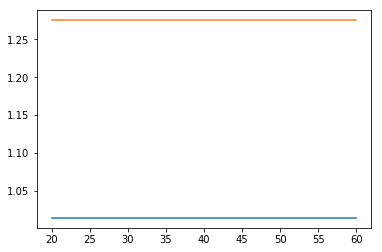

In [629]:
plt.plot(plotdata_max_k.k,plotdata_max_k.MAE,label
        plotdata_max_k.k,plotdata_max_k.RMSE)

In [630]:
plotdata_sim = plotdata[plotdata.min_k <2]
plotdata_sim = plotdata_sim[plotdata_sim.min_support == 3]
plotdata_sim = plotdata_sim[plotdata_sim.k == 40]
plotdata_sim

,MAE,RMSE,k,min_k,sim_matric,min_support
55,1.014266,1.275161,40,1,msd,3
58,1.014266,1.275161,40,1,cosine,3
61,1.014831,1.275106,40,1,pearson,3


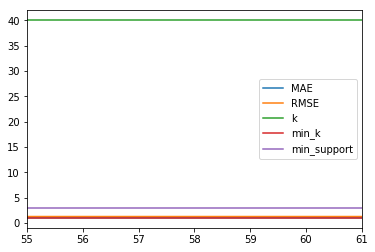

In [631]:
plotdata_sim.plot()

In [633]:
plotdata_mink = plotdata[plotdata.sim_matric =='cosine']
plotdata_mink = plotdata_mink[plotdata_mink.min_support == 3]
plotdata_mink = plotdata_mink[plotdata_mink.k == 40]
plotdata_mink

,MAE,RMSE,k,min_k,sim_matric,min_support
58,1.014266,1.275161,40,1,cosine,3
67,1.014831,1.275106,40,5,cosine,3
76,1.014831,1.275106,40,10,cosine,3


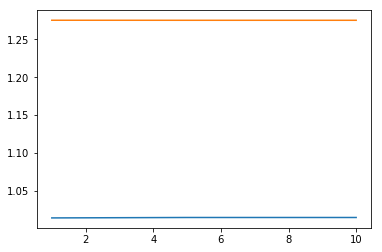

In [634]:
plt.plot(plotdata_mink.min_k,plotdata_mink.MAE,
        plotdata_mink.min_k,plotdata_mink.RMSE)